# Library

In [78]:
import pandas as pd
import numpy as np
from transformers import pipeline
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests
from dotenv import load_dotenv
import os

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA

# API

In [ ]:
#NY Times
load_dotenv()
NY_Times_Key= os.getenv('NY_Times_Key')

url= f'https://api.nytimes.com/svc/news/v3/content/section-list.json?api-key={NY_Times_Key}'
response=requests.get(url)
response

In [ ]:
url= f'https://api.nytimes.com/svc/news/v3/content/all/business.json?api-key={NY_Times_Key}'
response=requests.get(url)
response

In [ ]:
data=response.json()
data

In [ ]:
results = data.get('results', [])
df_ny_times=pd.json_normalize(results)

df_ny_times.to_json('df_ny_times.json')
df_ny_times=pd.read_json('df_ny_times.json')

df_ny_times

In [ ]:
current_date = datetime.now().strftime('%Y-%m-%d_%H-%M')
filename = f'df_ny_times_{current_date}.csv'
df_ny_times.to_csv(filename, index=False)

# Sentiment Analysis

## Pre processing

In [38]:
data_NY_TIMES= pd.read_csv('df_ny_times_2025-02-27_17-51.csv')
data_NY_TIMES.head()

,slug_name,section,subsection,title,abstract,uri,url,byline,item_type,source,...,first_published_date,material_type_facet,kicker,subheadline,des_facet,org_facet,per_facet,geo_facet,related_urls,multimedia
0,27Alaska-Gas,Business,NaN,Trump’s Tariff Threats Revive Interest in $44 ...,As the president pressures countries to buy mo...,nyt://article/fb7920b8-8843-509b-ac4e-c8d941a7...,https://www.nytimes.com/2025/02/27/business/tr...,By River Akira Davis,Article,New York Times,...,2025-02-27T11:06:27-05:00,News,NaN,NaN,"['Natural Gas', 'Global Warming', 'United Stat...","['MITSUI & CO', 'Mitsui Oil Exploration Corp']","['Trump, Donald J']","['Alaska', 'Japan']",[],[{'url': 'https://static01.nyt.com/images/2025...
1,27db-newsletter-web,Business,DealBook,A Union Takes On Musk via Tesla’s Stock,The American Federation of Teachers is pressur...,nyt://article/ae22882d-a3ab-55c1-93fe-1cf9a45d...,https://www.nytimes.com/2025/02/27/business/de...,"By Andrew Ross Sorkin, Ravi Mattu, Bernhard Wa...",Article,New York Times,...,2025-02-27T07:53:36-05:00,News,DealBook Newsletter,NaN,"['internal-storyline-no', 'Organized Labor', '...","['American Federation of Teachers', 'Tesla Mot...","['Trump, Donald J', 'Musk, Elon', 'Fink, Laure...",[],[],[{'url': 'https://static01.nyt.com/images/2025...
2,27game-shows,Business,Media,‘Jeopardy!’ and ‘Wheel of Fortune’ to Leap to ...,Sony Pictures Entertainment is soliciting bids...,nyt://article/f8ae812f-21c2-5964-b7f7-4d156ea2...,https://www.nytimes.com/2025/02/27/business/me...,By John Koblin,Article,New York Times,...,2025-02-27T05:04:01-05:00,News,NaN,NaN,"['Television', 'Web-Original Programming', 'Ra...","['CBS Corporation', 'Sony Corporation']",[],[],[],[{'url': 'https://static01.nyt.com/images/2025...
3,27dc-trump-econ,Business,NaN,U.S. Economy Shows Signs of Strain From Trump’...,Consumer and business sentiment is wobbling as...,nyt://article/93cf6523-170a-5e2d-a052-d3dbfcbd...,https://www.nytimes.com/2025/02/27/business/tr...,By Alan Rappeport,Article,New York Times,...,2025-02-27T05:02:33-05:00,News,NaN,NaN,"['United States Economy', 'Customs (Tariff)', ...","['Apollo Global Management', 'American Enterpr...","['Trump, Donald J', 'Strain, Michael R', 'Bess...",[],[],[{'url': 'https://static01.nyt.com/images/2025...
4,27mubi,Business,Media,How ‘The Substance’ Helped Mubi Break Through,The niche movie streaming service has become a...,nyt://article/bad611d2-f622-5bc1-a48f-7ac1b636...,https://www.nytimes.com/2025/02/27/business/me...,By Nicole Sperling,Article,New York Times,...,2025-02-27T05:02:17-05:00,News,NaN,NaN,"['Movies', 'Actors and Actresses', 'Academy Aw...","['MUBI Inc', 'Universal Pictures']","['Moore, Demi', 'Efe Cakarel']",[],[],[{'url': 'https://static01.nyt.com/images/2025...


In [39]:
data_NY_TIMES=data_NY_TIMES.loc[:,['first_published_date','title','abstract']]

In [40]:
df_SA_NY_TIMES['first_published_date'] = pd.to_datetime(df_SA_NY_TIMES['first_published_date'])
df_SA_NY_TIMES['first_published_date'] = df_SA_NY_TIMES['first_published_date'].dt.tz_localize(None)


In [46]:
data_NY_TIMES['title_abstract_concat']=data_NY_TIMES['title']+' '+data_NY_TIMES['abstract']
data_NY_TIMES.head()

,first_published_date,title,abstract,title_abstract_concat
0,2025-02-27T11:06:27-05:00,Trump’s Tariff Threats Revive Interest in $44 ...,As the president pressures countries to buy mo...,Trump’s Tariff Threats Revive Interest in $44 ...
1,2025-02-27T07:53:36-05:00,A Union Takes On Musk via Tesla’s Stock,The American Federation of Teachers is pressur...,A Union Takes On Musk via Tesla’s Stock The Am...
2,2025-02-27T05:04:01-05:00,‘Jeopardy!’ and ‘Wheel of Fortune’ to Leap to ...,Sony Pictures Entertainment is soliciting bids...,‘Jeopardy!’ and ‘Wheel of Fortune’ to Leap to ...
3,2025-02-27T05:02:33-05:00,U.S. Economy Shows Signs of Strain From Trump’...,Consumer and business sentiment is wobbling as...,U.S. Economy Shows Signs of Strain From Trump’...
4,2025-02-27T05:02:17-05:00,How ‘The Substance’ Helped Mubi Break Through,The niche movie streaming service has become a...,How ‘The Substance’ Helped Mubi Break Through ...


## Model

In [47]:
# Load the classification pipeline with the specified model
pipe = pipeline("text-classification", model="tabularisai/multilingual-sentiment-analysis")

Device set to use cpu


In [43]:
data = []

for text in data_NY_TIMES['title_abstract_concat']:
    result = pipe(text)
    data.append(result[0])  # Ajouter le premier (et seul) dictionnaire

df_SA_NY_TIMES = pd.DataFrame(data)
df_SA_NY_TIMES['first_published_date']=data_NY_TIMES['first_published_date']

df_SA_NY_TIMES

,label,score,first_published_date
0,Very Positive,0.245037,2025-02-27T11:06:27-05:00
1,Neutral,0.360990,2025-02-27T07:53:36-05:00
2,Very Positive,0.393650,2025-02-27T05:04:01-05:00
3,Very Negative,0.350729,2025-02-27T05:02:33-05:00
4,Very Positive,0.576578,2025-02-27T05:02:17-05:00
5,Very Negative,0.237676,2025-02-27T00:31:23-05:00
6,Very Negative,0.361027,2025-02-26T17:25:03-05:00
7,Neutral,0.351365,2025-02-26T17:16:52-05:00
8,Neutral,0.375914,2025-02-26T12:45:07-05:00
9,Neutral,0.452773,2025-02-26T11:00:44-05:00


In [44]:
sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
inverted_sentiment_map = {v: k for k, v in sentiment_map.items()}
df_SA_NY_TIMES['sentiment_value'] = df_SA_NY_TIMES['label'].map(inverted_sentiment_map)
df_SA_NY_TIMES

,label,score,first_published_date,sentiment_value
0,Very Positive,0.245037,2025-02-27T11:06:27-05:00,4
1,Neutral,0.360990,2025-02-27T07:53:36-05:00,2
2,Very Positive,0.393650,2025-02-27T05:04:01-05:00,4
3,Very Negative,0.350729,2025-02-27T05:02:33-05:00,0
4,Very Positive,0.576578,2025-02-27T05:02:17-05:00,4
5,Very Negative,0.237676,2025-02-27T00:31:23-05:00,0
6,Very Negative,0.361027,2025-02-26T17:25:03-05:00,0
7,Neutral,0.351365,2025-02-26T17:16:52-05:00,2
8,Neutral,0.375914,2025-02-26T12:45:07-05:00,2
9,Neutral,0.452773,2025-02-26T11:00:44-05:00,2


## Visualization 

In [45]:
label_order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
fig=px.histogram(data_frame=df_SA_NY_TIMES,
                x='label',y='score',
                category_orders={"label": label_order},
                labels={"label": "Label", "score": "Score"},  # Renommer les axes
                title="Distribution des scores par label avec ordre progressif")

fig.show()

# Mise en forme Time Series

In [48]:
df_SA_NY_TIMES

,label,score,first_published_date,sentiment_value
0,Very Positive,0.245037,2025-02-27T11:06:27-05:00,4
1,Neutral,0.360990,2025-02-27T07:53:36-05:00,2
2,Very Positive,0.393650,2025-02-27T05:04:01-05:00,4
3,Very Negative,0.350729,2025-02-27T05:02:33-05:00,0
4,Very Positive,0.576578,2025-02-27T05:02:17-05:00,4
5,Very Negative,0.237676,2025-02-27T00:31:23-05:00,0
6,Very Negative,0.361027,2025-02-26T17:25:03-05:00,0
7,Neutral,0.351365,2025-02-26T17:16:52-05:00,2
8,Neutral,0.375914,2025-02-26T12:45:07-05:00,2
9,Neutral,0.452773,2025-02-26T11:00:44-05:00,2


In [63]:
# Assumons que df_SA_NY_TIMES est votre DataFrame d'origine
# Convertir la colonne 'first_published_date' en datetime
df_SA_NY_TIMES['first_published_date'] = pd.to_datetime(df_SA_NY_TIMES['first_published_date'])

# Formater la date dans le format 'année-mois-jour-heure-minute'
df_SA_NY_TIMES['date'] = df_SA_NY_TIMES['first_published_date'].dt.strftime('%Y-%m-%d_%H-%M')

# Mapper les valeurs de sentiment à leurs labels
sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
df_SA_NY_TIMES['sentiment_label'] = df_SA_NY_TIMES['sentiment_value'].map(sentiment_map)

# Calculer la moyenne des scores par label
average_scores = df_SA_NY_TIMES.groupby('label')['score'].mean().reset_index()

# Calculer la fréquence des valeurs de sentiment
sentiment_frequency = df_SA_NY_TIMES['sentiment_label'].value_counts().reset_index()
sentiment_frequency.columns = ['label', 'frequency']

# Fusionner les deux DataFrames
df_TS = pd.merge(average_scores, sentiment_frequency, on='label', how='outer')

# Ajouter la colonne 'formatted_date' dans df_TS si vous voulez la conserver dans le tableau final
# Ici, nous l'ajoutons comme une colonne séparée pour chaque label.
df_TS['formatted_date'] = df_SA_NY_TIMES['formatted_date'].iloc[0]  # Vous pouvez ajuster ceci selon la logique désirée

# Afficher le résultat
print(df_TS)

           label     score  frequency    formatted_date
0       Negative  0.366189          2  2025-02-27_11-06
1        Neutral  0.381897         11  2025-02-27_11-06
2  Very Negative  0.339155          4  2025-02-27_11-06
3  Very Positive  0.405088          3  2025-02-27_11-06


In [65]:
# Check stationarity
result = adfuller(df_TS['frequency'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.050588887121774
p-value: 0.2648412291685313


In [71]:
# Pivot the data to have labels as columns and dates as index
pivot_df = df_TS.pivot(index='formatted_date', columns='label', values='frequency').fillna(0)


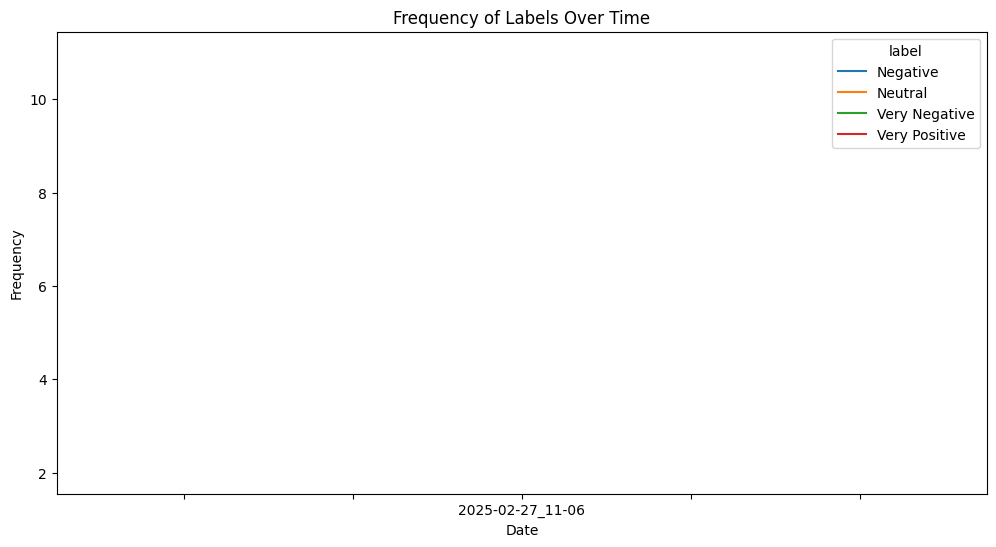

In [74]:
# Plot the time series for each label
pivot_df.plot(figsize=(12, 6))
plt.title('Frequency of Labels Over Time')
plt.ylabel('Frequency')
plt.xlabel('Date')
plt.show()

In [75]:
# Fit ARIMA model for each label
arima_models = {}
for label in pivot_df.columns:
    model = ARIMA(pivot_df[label], order=(1, 1, 1))  # Example order (p, d, q)
    arima_models[label] = model.fit()
    print(f"ARIMA Model Summary for {label}:\n{arima_models[label].summary()}")


ARIMA Model Summary for Negative:
                               SARIMAX Results                                
Dep. Variable:               Negative   No. Observations:                    1
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   0.000
Date:                Wed, 05 Mar 2025   AIC                              6.000
Time:                        16:44:23   BIC                               -inf
Sample:                             0   HQIC                               nan
                                  - 1                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0        nan        nan        nan         nan         nan
ma.L1               0        nan        nan        nan         nan         nan
sigma2         1.0

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting 

In [76]:
# Forecasting
forecast_steps = 5  # Number of steps to forecast
forecasts = {}
for label, model in arima_models.items():
    forecasts[label] = model.forecast(steps=forecast_steps)
    print(f"Forecast for {label}: {forecasts[label]}")

Forecast for Negative: 1    2.0
2    2.0
3    2.0
4    2.0
5    2.0
Name: predicted_mean, dtype: float64
Forecast for Neutral: 1    11.0
2    11.0
3    11.0
4    11.0
5    11.0
Name: predicted_mean, dtype: float64
Forecast for Very Negative: 1    4.0
2    4.0
3    4.0
4    4.0
5    4.0
Name: predicted_mean, dtype: float64
Forecast for Very Positive: 1    3.0
2    3.0
3    3.0
4    3.0
5    3.0
Name: predicted_mean, dtype: float64


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/zeus/miniconda3/envs/cloudspace/lib

DateParseError: Unknown datetime string format, unable to parse: 2025-02-27_11-06

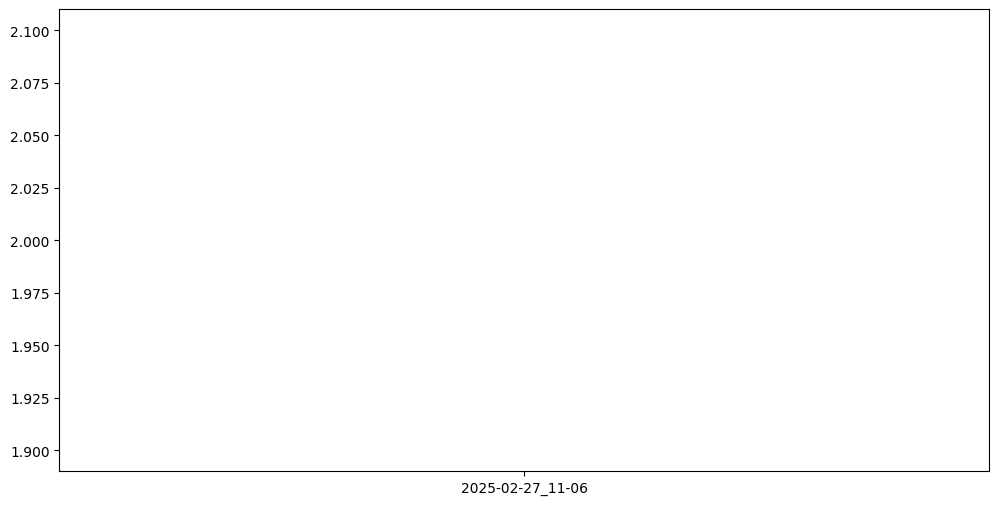

In [77]:
# Plot forecasts
plt.figure(figsize=(12, 6))
for label in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[label], label=f'{label} Actual')
    plt.plot(pd.date_range(start=pivot_df.index[-1], periods=forecast_steps, freq='H'), forecasts[label], label=f'{label} Forecast', linestyle='--')
plt.title('Forecast of Label Frequencies')
plt.ylabel('Frequency')
plt.xlabel('Date')
plt.legend()
plt.show()

In [79]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA

# Example data
data = {
    'formatted_date': ['2025-02-27_11-06'] * 4,
    'label': ['Negative', 'Neutral', 'Very Negative', 'Very Positive'],
    'frequency': [2, 11, 4, 3]
}
df = pd.DataFrame(data)

# Convert formatted_date to datetime
df['formatted_date'] = pd.to_datetime(df['formatted_date'], format='%Y-%m-%d_%H-%M')

# Pivot the data to have labels as columns and dates as index
pivot_df = df.pivot(index='formatted_date', columns='label', values='frequency').fillna(0)

# Custom ARIMA estimator
class ARIMAModel(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 0, 0)):
        self.order = order
        self.model = None

    def fit(self, X, y):
        self.model = ARIMA(y, order=self.order)
        self.model_fit = self.model.fit()
        return self

    def predict(self, X):
        return self.model_fit.forecast(steps=len(X))

    def get_params(self, deep=True):
        return {"order": self.order}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Define the parameter grid
param_grid = {
    'order': [(p, d, q) for p in range(3) for d in range(2) for q in range(3)]
}

# Perform grid search for each label
best_models = {}
for label in pivot_df.columns:
    print(f"Grid search for {label}:")
    arima = ARIMAModel()
    grid_search = GridSearchCV(arima, param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(np.zeros(len(pivot_df[label])), pivot_df[label])
    best_models[label] = grid_search.best_estimator_
    print(f"Best parameters for {label}: {grid_search.best_params_}")

# Output the best models
for label, model in best_models.items():
    print(f"\nBest ARIMA Model for {label}:\n{model.model_fit.summary()}")


Grid search for Negative:


ValueError: Cannot have number of splits n_splits=3 greater than the number of samples: n_samples=1.